## **Generative Adversarial Network (적대적 생성 신경망)**

#### Table of Contents
0. 실습목표
1. Hyperparameter 설정
2. 데이터셋 불러오기
3. **Vanilla GAN 구현**   \
    3.1 Generator 모듈 구현\
    3.2 Discriminator 모듈 구현\
    3.3 Loss Function and Optimizer\
    3.4 Discriminator train 함수 구현\
    3.5 Generator train 함수 구현\
    3.6 GAN training 
4. **cGAN 구현**  \
    4.1 Generator 모듈 구현\
    4.2 Discriminator 모듈 구현\
    4.3 Loss Function and Optimizer\
    4.4 Discriminator train 함수 구현\
    4.5 Generator train 함수 구현\
    4.6 cGAN training
5. **cDCGAN 구현**  \
    5.1 Generator 모듈 구현\
    5.2 Discriminator 모듈 구현\
    5.3 Loss Function and Optimizer\
    5.4 Discriminator train 함수 구현\
    5.5 Generator train 함수 구현\
    5.6 cDCGAN training


### **0. 실습 목표**

**MNIST dataset을 활용한 GAN 학습 및 이미지 생성 확인**

1. **Vanilla GAN**: 가장 기본적인 fully connected layer로 이루어진 GAN
2. **cGAN**: conditional GAN의 약자로써 원하는 class의 이미지를 생성할 수 있는 GAN
3. **cDCGAN**: conditional Deep Convolutional GAN의 약자로써 convolution과 deconvolution layer로 이루어진 GAN

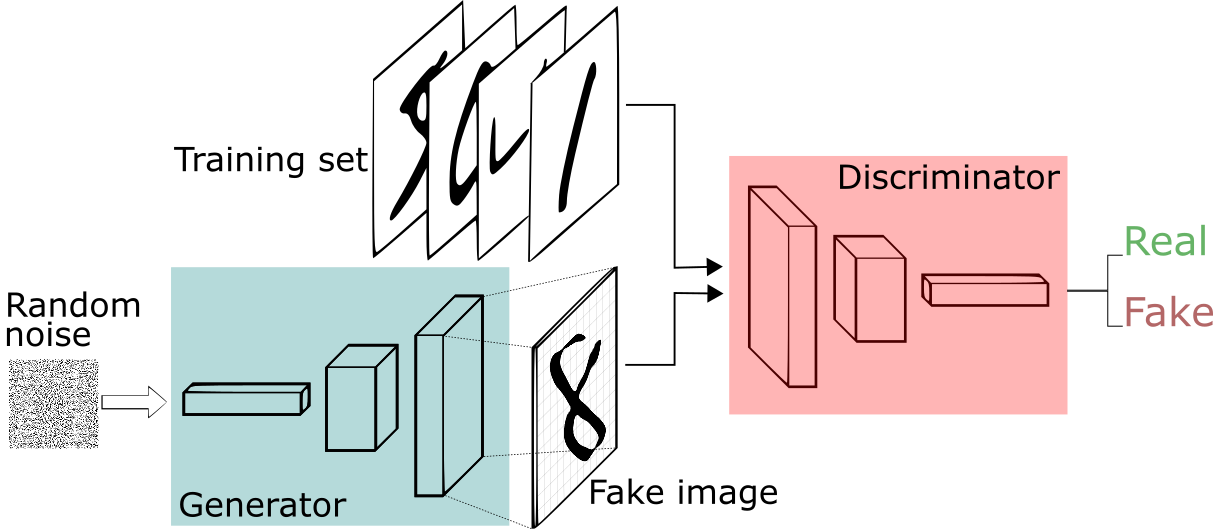

**GAN(Generative adversarial network)**
- 생성자(Generator)와 구분자(Discriminator)가 서로 대립(Adversarial)하며 데이터를 생성하는 모델
- 예를들어 mnist dataset의 0~9까지 숫자 이미지의 경우를 보자

- **생성자(Generator)**
    - 입력: 100차원의 noise (z)
    - 출력: mnist 이미지와 동일한 크기/형태의 가짜 숫자 이미지
    - 훈련 방향: 더 진짜 같은 이미지를 출력하도록 훈련

- **구분자(Discriminator)**
    - 입력: mnist 이미지 크기의 숫자 이미지
    - 출력: 진짜 이미지(실제 mnist data)이면 1, 가짜 이미지(generator 생성 이미지)이면 0
    - 훈련 방향: 진짜 이미지와 가짜 이미지를 구분할 수 있도록 훈련

- Random noise distribution으로부터 원하는 이미지를 생성해내기 때문에 이를 latent space라고 부르며 mnist의 경우 latent dimension=100으로 설정하는데, 100-차원의 noise를 입력으로 generator가 가짜 숫자 이미지를 생성

In [1]:
import argparse 
import os
import numpy as np
import math
import itertools

# torchvision
import torchvision.transforms as transforms

# torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from IPython import display

### **1. Hyperparameter 설정**

MNIST dataset GAN training 에 필요한 hyperparameter를 설정
- latent_dim = 100은 Random noise z의 차원을 100차원으로 설정
- Network initialization을 위한 function 정의



In [2]:
batch_size = 128                                   # size of the batches
img_size = 28                                      # size of each image dimension
n_channels = 1                                     # MNIST data number of image channels
n_classes = 10                                     # MNIST number of classes
img_shape = (n_channels, img_size, img_size)       # MNIST data image shape

latent_dim = 100                                   # dimensionality of the latent space

cuda = True if torch.cuda.is_available() else False
device = 'cuda:0' if cuda else 'cpu'

seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

### **2. 데이터셋 불러오기**
- MNIST dataset: 0에서 9사이 숫자를 손으로 쓴 60000개의 28 * 28 pixel grayscale 이미지로 구성된 dataset
- DataLoader을 이용해서 60000개의 이미지를 원하는 batch size의 batch 단위로 구성
- 60000개의 이미지를 128개씩 나누었기 때문에 train_loader의 크기는 floor(60000/128) = 469
- 이미지 데이터 확인을 위해 임의의 10개 이미지 plot

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Size of train data loader:  469



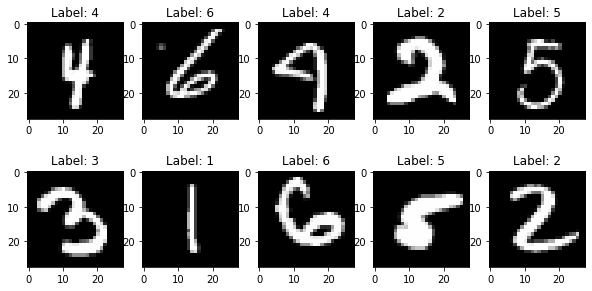

In [3]:
#데이터 전처리 방식을 지정한다.
transform = transforms.Compose([
  transforms.ToTensor(),                            # 데이터를 파이토치의 Tensor 형식으로바꾼다.
  transforms.Normalize(mean=(0.5,), std=(0.5,))     # 픽셀값 0 ~ 1 -> -1 ~ 1
])

mnist_train  = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# train loader size
print('Size of train data loader: ', len(train_loader)) 

# 임의의 MNIST test data image plot
fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

examples = enumerate(train_loader)
_, (ex_data, ex_targets) = next(examples)

for i in range(10):
    ax = axes[i//5,i%5]
    ax.imshow(ex_data[i][0],cmap='gray')
    ax.set_title('Label: {}'.format(ex_targets[i]))

plt.show()




### **3. Vanilla GAN 구현**




#### 3-1. Generator 모듈 구현

- Fully connected layer로 100차원 입력 -> 784차원 출력 생성 -> (1,28,28)로 reshape


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, z):
        img = self.model(z.view(z.size(0),-1))
        img = img.view(img.size(0), *img_shape)
        return img


#### 3-2. Discriminator 모듈 구현

- Fully connected layer로 784차원 입력 -> 0(가짜)/1(진짜) 예측 출력


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, img):
        out = self.model(img.view(img.size(0), -1))
        out = out.view(-1)
        return out

#### 3-3. Loss Function and Optimizer

- Generator / Disciriminator 모델 선언
- Weight 훈련을 위한 Learning rate 설정, Loss function 선언
- Generator optimizer, Discriminator optimizer 선언


In [6]:
lr = 0.0002                                            # "adam: learning rate"

# Loss function
criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()
generator.weight_init(mean=0.0,std=0.02)
discriminator.weight_init(mean=0.0,std=0.02)

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

#### 3-4. Distriminator train 함수 구현
- 실제 훈련 과정에서 discriminator loss 계산과 parameter update하는 함수 구현
- 훈련을 위한 진짜 이미지가 들어오면 discriminator output과 1을 비교한 loss 계산 (real loss)
- 구분을 위해 가짜 이미지를 z->G(z)로 생성하여 discriminator output과 0을 비교한 loss 계산 (fake loss)
- total discriminator loss = real loss + fake loss

In [8]:
def train_discriminator(discriminator, generator, images):
    d_optimizer.zero_grad()                                                      # gradient를 0으로 초기화
    
    # real image pytorch 형태로 변경
    real_images = Variable(images).to(device)                                      # real images
    real_labels_output = Variable(torch.ones(images.size(0))).to(device)             # real images의 discriminator output 생성 (1)

    # train with real images
    real_validity = discriminator(real_images)                                   # 실제 image들을 분류기에 넣고 돌린 결과(진짜인지 아닌지) -  1:진짜, 0:가짜
    real_loss =                      # output과 실제 이미지 결과(1)와 비교하여 loss 계산

    # fake image 생성
    z = Variable(torch.randn(images.size(0), latent_dim)).to(device)                 # noise 생성
    fake_images = generator(z)                                                   # generator에 noise를 넣어 fake image 생성
    fake_labels_output = Variable(torch.zeros(images.size(0))).to(device)            # fake images의 discriminator output 생성 (0)

    # train with fake images
    fake_validity = discriminator(fake_images)                                   # fake 이미지들을 분류기에 넣고 돌린 결과
    fake_loss =                      # output과 가짜 이미지 결과(0)과 비교하여 loss 계산

    d_loss = real_loss + fake_loss                                               # descriminator의 loss는 두 loss를 더한 것
    d_loss.backward()                                                            # 오차 역전파
    d_optimizer.step()                                                           # parameter update

    return d_loss.item()

#### 3-5. Generator train 함수 구현

- 실제 훈련 과정에서 generator loss 계산과 parameter update하는 함수 구현
- 가짜 이미지를 z->G(z)로 생성하여 discriminator로 test
- discriminator output이 실제 이미지 output과 구분이 어렵도록 1과 비교한 loss 계산

In [9]:
def train_generator(generator, discriminator, batch_size):
    g_optimizer.zero_grad()                                                      # gradient 0으로 초기화
    
    real_labels_output = Variable(torch.ones(batch_size)).to(device)                 # real images의 discriminator output 생성 (1)

    # fake validity 측정
    z = Variable(torch.randn(batch_size, latent_dim)).to(device)                     # noise 생성
    fake_images = generator(z)                                                   # generator에 noise를 넣어 fake image 생성
    fake_validity = discriminator(fake_images)                                   # fake 이미지들을 분류기에 넣고 돌린 결과

    # discriminator에 fake data를 넣었을 때와 실제 label을 비교
    g_loss = criterion(fake_validity, real_labels_output)                        # loss 계산 -> Discriminator에 fake-data를 넣었을 때 결과와
                                                                                 # 실제 이미지 결과(1)을 비교, 이 부분이 핵심

    g_loss.backward()                                                            # 역전파
    g_optimizer.step()                                                           # parameter update

    return g_loss.item()

#### 3-6. GAN training
- Epoch마다 discriminator 훈련 -> generator 훈련 반복
- 이론적으로 Generator loss와 Discriminator loss의 차이가 없어질 때까지 training 하는 것이 기본 concept이므로 tracking을 위해 두 loss를 저장 (Epoch 안에 여러 batch가 존재하므로 average loss 저장)
- 시간 관계상 n_epochs=10으로 설정되어 있으나, 더 크게 설정하여 깨끗한 숫자 이미지를 생성 가능

Epoch [  1/ 10], Step[469/469], d_loss: 0.6332, g_loss: 2.0216
Epoch [  2/ 10], Step[469/469], d_loss: 0.9805, g_loss: 2.3714
Epoch [  3/ 10], Step[469/469], d_loss: 1.2245, g_loss: 1.8241
Epoch [  4/ 10], Step[469/469], d_loss: 1.0387, g_loss: 1.5274
Epoch [  5/ 10], Step[469/469], d_loss: 0.9882, g_loss: 1.8976
Epoch [  6/ 10], Step[469/469], d_loss: 0.4749, g_loss: 2.6970
Epoch [  7/ 10], Step[469/469], d_loss: 0.5581, g_loss: 2.7860
Epoch [  8/ 10], Step[469/469], d_loss: 0.5128, g_loss: 3.5923
Epoch [  9/ 10], Step[469/469], d_loss: 0.3027, g_loss: 4.6008
Epoch [ 10/ 10], Step[469/469], d_loss: 0.2285, g_loss: 5.4265


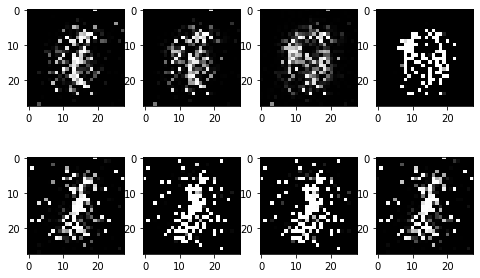

In [10]:
D_losses = []
G_losses = []

n_epochs = 10                                                                    # "number of epochs of training"

for epoch in range(n_epochs):
    d_avg_loss = 0
    g_avg_loss = 0

    for n, (images, _) in enumerate(train_loader):
        d_loss = train_discriminator(discriminator, generator, images)           # Discriminator 학습
        g_loss = train_generator(generator, discriminator, batch_size)           # Generator를 학습

        d_avg_loss += d_loss
        g_avg_loss += g_loss

    d_avg_loss /= len(train_loader)
    g_avg_loss /= len(train_loader)
    D_losses.append(d_avg_loss)
    G_losses.append(g_avg_loss)

    print('Epoch [%3d/%3d], Step[%3d/%3d], d_loss: %.4f, g_loss: %.4f' 
          %(epoch + 1, n_epochs, n+1, len(train_loader), d_avg_loss, g_avg_loss))
    
    if (epoch % 10) == 9:                                                        # training 도중 generated image 확인하고 싶은 epoch 설정
        ## test sample을 만들어서 generator로 만든 data sample 이미지 확인
        num_test_samples = 8
        test_noise = Variable(torch.randn(num_test_samples, latent_dim).to(device))
        fig,axes = plt.subplots(2,4,figsize=(2*4,2.5*2))

        test_images = generator(test_noise)

        for i in range(num_test_samples):
            ax = axes[i//4,i%4]
            ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

        plt.show()

- Training의 결과로 test sample 8개에 대한 생성 이미지 확인

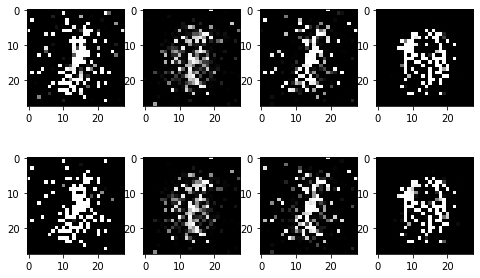

In [11]:
## test sample을 만들어서 generator로 만든 data sample 이미지 확인

num_test_samples = 8
test_noise = Variable(torch.randn(num_test_samples, latent_dim).to(device))

fig,axes = plt.subplots(2,4,figsize=(2*4,2.5*2))

test_images = generator(test_noise)

for i in range(num_test_samples):
    ax = axes[i//4,i%4]
    ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

plt.show()

- n_epochs을 키워서 더 길게 training하면 다음과 같은 결과를 얻을 수 있음

    - n_epochs=100:

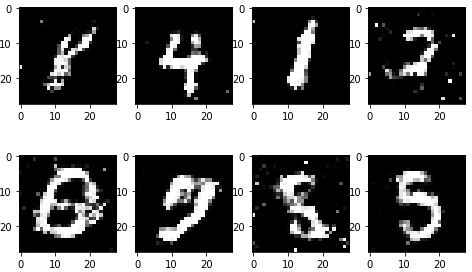

- MNIST vanilla GAN training에 보통 n_epochs=200 적용
    - n_epochs=200:

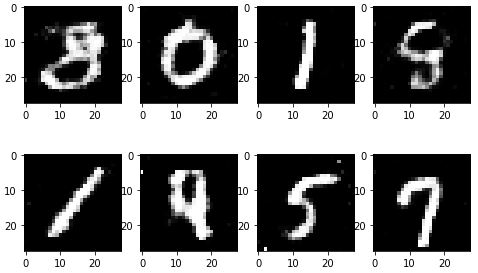

- Tracking을 위해 generator loss와 discriminator loss 변화 plot

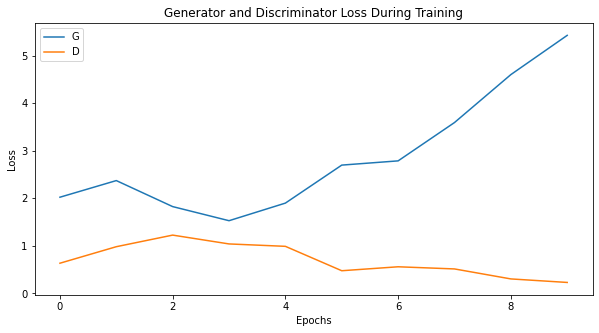

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

- n_epochs=200의 loss tracking plot은 다음과 같음:
    - epoch이 지남에 따라 두 loss의 차이가 줄어드는 경향을 확인 가능
    - 다만, loss의 차가 사라진 것이 GAN의 성능을 보장해주지는 않음. GAN의 성능을 평가하는 평가 기준들에 대해서는 아직도 연구들이 진행 중임


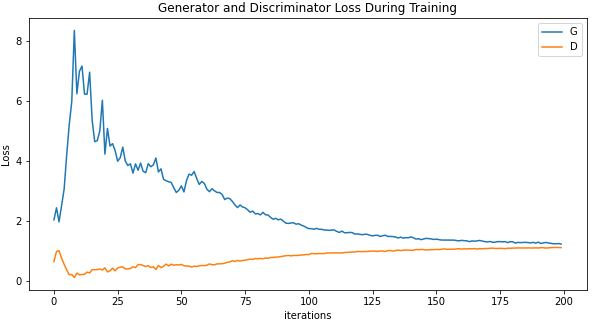

### **4. cGAN 구현**


#### 4-1. Generator 모듈 구현
- cGAN generator는 원하는 이미지 생성을 위해 noise와 함께 label을 입력으로 받음
- 100차원 z 입력 -> 입력 label embedding 후 결합 -> fully connected layer로 784차원 출력 생성 -> (1,28,28)로 reshape

In [13]:
class cGAN_Generator(nn.Module):
    def __init__(self, n_classes=10):
        super(cGAN_Generator, self).__init__()

        self.label_emb = nn.Embedding(10, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, z, labels):
        z = z.view(z.size(0), -1)
        c = self.label_emb(labels).view(z.size(0),-1)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), img_size, img_size)


#### 4-2. Discriminator 모듈 구현
- cGAN discriminator는 class에 해당하는 이미지를 구분하기 위해 구분을 위한 이미지와 함께 label을 입력으로 받음
- 784차원 입력 -> 입력 label embedding 후 결합 -> fully connected layer로 0/1 예측 생성

In [14]:
class cGAN_Discriminator(nn.Module):
    def __init__(self,n_classes=10):
        super(cGAN_Discriminator, self).__init__()

        self.label_emb = nn.Embedding(10, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x, labels):
        x = x.view(x.size(0), -1)
        c = self.label_emb(labels.long())
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

#### 4-3. Loss Function and Optimizer

- 이제부터 위의 vanilla GAN을 참고하여 같은 순서대로 cGAN 또한 train 가능!
- Generator / Disciriminator 모델 선언
- Weight 훈련을 위한 Learning rate 설정, Loss function 선언
- Generator optimizer, Discriminator optimizer 선언




In [15]:
cGAN_lr = 0.0002                                                                      # "adam: learning rate"

# Loss functions
cGAN_criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
cGAN_generator = cGAN_Generator()
cGAN_discriminator = cGAN_Discriminator()
cGAN_generator.weight_init(mean=0.0,std=0.02)
cGAN_discriminator.weight_init(mean=0.0,std=0.02)

if cuda:
    cGAN_generator.cuda()
    cGAN_discriminator.cuda()
    cGAN_criterion.cuda()

# Optimizers
cGAN_g_optimizer = torch.optim.Adam(cGAN_generator.parameters(), lr=cGAN_lr)
cGAN_d_optimizer = torch.optim.Adam(cGAN_discriminator.parameters(), lr=cGAN_lr)

#### 4-4. Distriminator train 함수 구현

- 실제 훈련 과정에서 discriminator loss 계산과 parameter update하는 함수 구현
- generator와 discriminator에 이미지 레이블을 입력으로 넣는 것 외에는 위와 동일

In [16]:
def cGAN_train_discriminator(cGAN_discriminator, cGAN_generator, images, labels):
    cGAN_d_optimizer.zero_grad()                                                 # parameter를 0으로 초기화

    # real image/label pytorch 형태로 변경
    real_images = Variable(images).to(device)                                        # real images
    real_labels = Variable(labels).to(device)                                        # real labels
    real_labels_output = Variable(torch.ones(images.size(0))).to(device)             # real images의 discriminator output 생성 (1)

    # train with real images
    real_validity = cGAN_discriminator(real_images, real_labels)                 # 실제 image들을 분류기에 넣고 돌린 결과(진짜인지 아닌지) -  1:진짜, 0:가짜
    real_loss = cGAN_criterion(real_validity, real_labels_output).to(device)         # output과 실제 이미지 결과(1)와 비교하여 loss 계산
    
    # fake image/label 생성
    z = Variable(torch.randn(images.size(0), latent_dim)).to(device)                 # noise 생성
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, n_classes, images.size(0)))).to(device) # fake labels 생성 (random하게 생성)
    fake_images = cGAN_generator(z, fake_labels)                                 # generator에 noise를 넣어 fake image 생성
    fake_labels_output = Variable(torch.zeros(images.size(0))).to(device)            # fake images의 discriminator output 생성 (0)
    
    # train with fake images
    fake_validity = cGAN_discriminator(fake_images, fake_labels)                 # fake 이미지들을 분류기에 넣고 돌린 결과
    fake_loss = cGAN_criterion(fake_validity, fake_labels_output).to(device)         # output과 가짜 이미지 결과(0)과 비교하여 loss 계산
    
    d_loss = real_loss + fake_loss                                               # discriminator의 loss는 두 loss를 더한 것
    d_loss.backward()                                                            # 오차 역전파
    cGAN_d_optimizer.step()                                                      # parameter update
    
    return d_loss.item()

#### 4-5. Generator train 함수 구현

- 실제 훈련 과정에서 generator loss 계산과 parameter update하는 함수 구현
- generator와 discriminator에 이미지 레이블을 입력으로 넣는 것 외에는 위와 동일

In [17]:
def cGAN_train_generator(cGAN_discriminator, cGAN_generator, batch_size):
    cGAN_g_optimizer.zero_grad()

    real_labels_output = Variable(torch.ones(batch_size)).to(device)                 # real images의 discriminator output 생성 (1)

    # fake validity 측정
    z = Variable(torch.randn(batch_size, latent_dim)).to(device)                 # noise 생성
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device) # fake labels 생성 (random하게 생성) 
    fake_images = cGAN_generator(z, fake_labels)                                 # generator에 noise를 넣어 fake image 생성
    fake_validity = cGAN_discriminator(fake_images, fake_labels)                 # fake 이미지들을 분류기에 넣고 돌린 결과

    g_loss = cGAN_criterion(fake_validity, real_labels_output)                   # loss 계산 -> Discriminator에 fake-data를 넣었을 때 결과와
                                                                                 # 실제 이미지 결과(1)을 비교

    g_loss.backward()                                                            # 역전파
    cGAN_g_optimizer.step()                                                      # parameter update

    return g_loss.item()

#### 4-6. cGAN training
- Epoch마다 discriminator 훈련 -> generator 훈련 반복
- tracking을 위해 두 loss를 저장 (Epoch 안에 여러 batch가 존재하므로 average loss 저장)
- 시간 관계상 n_epochs=10으로 설정되어 있으나, 더 크게 설정하여 깨끗한 숫자 이미지를 생성 가능


Epoch [  1/ 10], Step[469/469], d_loss: 0.8447, g_loss: 3.3650
Epoch [  2/ 10], Step[469/469], d_loss: 1.1637, g_loss: 1.4900
Epoch [  3/ 10], Step[469/469], d_loss: 0.8798, g_loss: 2.1889
Epoch [  4/ 10], Step[469/469], d_loss: 0.6737, g_loss: 2.9339
Epoch [  5/ 10], Step[469/469], d_loss: 0.5071, g_loss: 3.1269
Epoch [  6/ 10], Step[469/469], d_loss: 0.4856, g_loss: 3.1645
Epoch [  7/ 10], Step[469/469], d_loss: 0.4112, g_loss: 3.1712
Epoch [  8/ 10], Step[469/469], d_loss: 0.4404, g_loss: 3.2722
Epoch [  9/ 10], Step[469/469], d_loss: 0.4866, g_loss: 2.9944
Epoch [ 10/ 10], Step[469/469], d_loss: 0.5184, g_loss: 2.9268


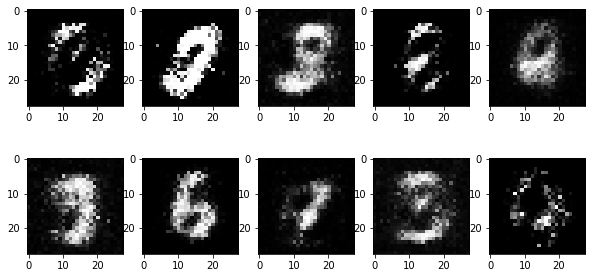

In [18]:
cGAN_D_losses = []
cGAN_G_losses = []

n_epochs = 10                                                                    # "number of epochs of training"
 
for epoch in range(n_epochs):
    cGAN_d_avg_loss = 0
    cGAN_g_avg_loss = 0

    for n, (images, labels) in enumerate(train_loader):
        d_loss = cGAN_train_discriminator(cGAN_discriminator, cGAN_generator, images, labels)       # Discriminator 학습
        g_loss = cGAN_train_generator(cGAN_discriminator, cGAN_generator, batch_size)               # Generator 학습

        cGAN_d_avg_loss += d_loss
        cGAN_g_avg_loss += g_loss

    cGAN_d_avg_loss /= len(train_loader)
    cGAN_g_avg_loss /= len(train_loader)
    cGAN_D_losses.append(cGAN_d_avg_loss)
    cGAN_G_losses.append(cGAN_g_avg_loss)

    print('Epoch [%3d/%3d], Step[%3d/%3d], d_loss: %.4f, g_loss: %.4f' 
          %(epoch + 1, n_epochs, n+1, len(train_loader), cGAN_d_avg_loss, cGAN_g_avg_loss))
    
    if (epoch % 10) == 9               :                                          # training 도중 generated image 확인하고 싶은 epoch 설정
        ## test samples(0~9)을 만들어서 generator로 만든 data sample 이미지 확인
        num_test_samples = n_classes
        test_noise = Variable(torch.randn(num_test_samples, latent_dim).to(device))
        test_labels = torch.LongTensor([i for i in range(n_classes)]).to(device)
        fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

        test_images = cGAN_generator(test_noise,test_labels)

        for i in range(num_test_samples):
            ax = axes[i//5,i%5]
            ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

        plt.show()

- Training의 결과로 test sample 0~9 class에 대한 생성 이미지 확인

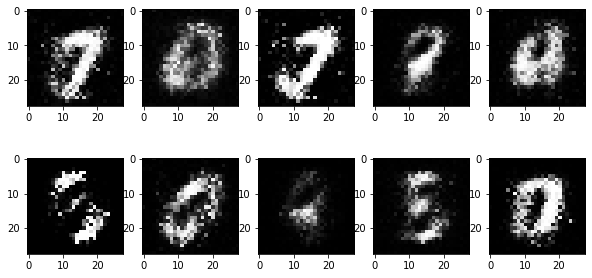

In [19]:
## test samples(0~9)을 만들어서 generator로 만든 data sample 이미지 확인
num_test_samples = n_classes
test_noise = Variable(torch.randn(num_test_samples, latent_dim).to(device))
test_labels = torch.LongTensor([i for i in range(n_classes)]).to(device)
fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

test_images = cGAN_generator(test_noise,test_labels)

for i in range(num_test_samples):
    ax = axes[i//5,i%5]
    ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

plt.show()

- n_epochs을 키워서 더 길게 training하면 다음과 같은 결과를 얻을 수 있음

    - n_epochs=100:

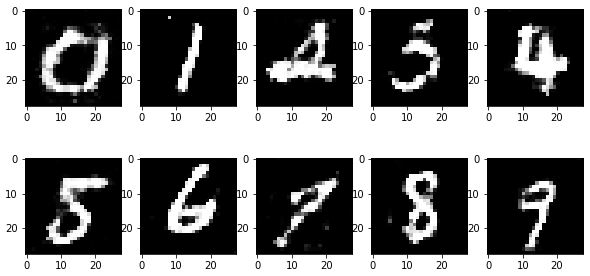

- Tracking을 위해 generator loss와 discriminator loss 변화 plot

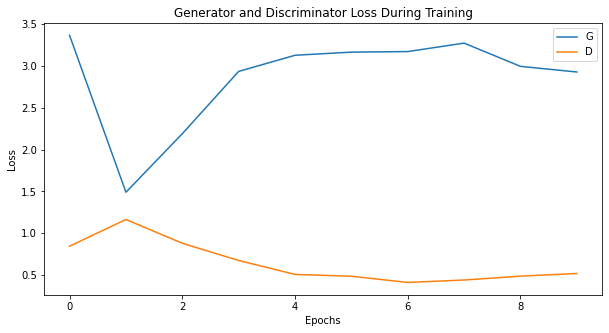

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(cGAN_G_losses,label="G")
plt.plot(cGAN_D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

- n_epochs=100의 loss tracking plot은 다음과 같음:

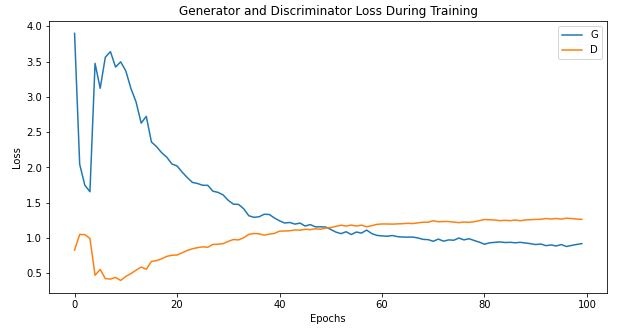

### **5. cDCGAN 구현**

#### 5-0. MNIST dataset loader

- Convolution을 위해 (28,28) 이미지를 (32,32) 이미지로 resize 해야하므로 dataset reload

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Size of train data loader:  469


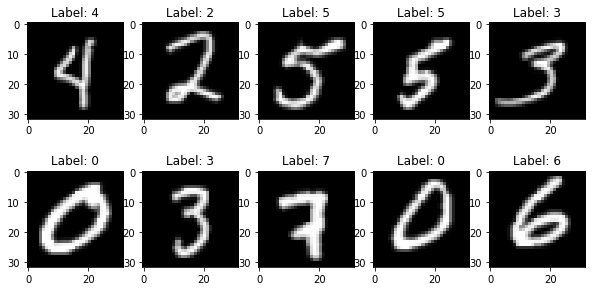

In [21]:
img_size = 32
num_filters = [512,256,128]

#데이터 전처리 방식을 지정한다.
transform = transforms.Compose([
                                transforms.Scale(img_size),                      # convolution을 위해 이미지 resize
                                transforms.ToTensor(),                           # 데이터를 파이토치의 Tensor 형식으로바꾼다.
                                transforms.Normalize(mean=(0.5,), std=(0.5,))    # 픽셀값 0 ~ 1 -> -1 ~ 1
])

mnist_train  = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# train loader size
print('Size of train data loader: ', len(train_loader)) 

# 임의의 MNIST test data image plot
fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

examples = enumerate(train_loader)
_, (ex_data, ex_targets) = next(examples)

for i in range(10):
    ax = axes[i//5,i%5]
    ax.imshow(ex_data[i][0],cmap='gray')
    ax.set_title('Label: {}'.format(ex_targets[i]))

plt.show()

#### 5-1. Generator 모듈 구현

- 100차원 noise 및 label 입력 -> convolutional layer로 (1,32,32) 출력 생성

In [22]:
class cDCGAN_Generator(nn.Module):
    def __init__(self, input_dim=latent_dim, label_dim=n_classes, num_filters=num_filters, output_dim=1):
        super(cDCGAN_Generator, self).__init__()
        
        # Hidden layers
        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                # For input
                input_deconv = torch.nn.ConvTranspose2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer1.add_module('input_deconv', input_deconv)

                # Initializer
                torch.nn.init.normal_(input_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(input_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer1.add_module('input_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.ReLU())

                # For label
                label_deconv = torch.nn.ConvTranspose2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer2.add_module('label_deconv', label_deconv)

                # Initializer
                torch.nn.init.normal_(label_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(label_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer2.add_module('label_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.ReLU())
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                deconv_name = 'deconv' + str(i + 1)
                self.hidden_layer.add_module(deconv_name, deconv)

                # Initializer
                torch.nn.init.normal_(deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(deconv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.ReLU())

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


#### 5-2. Discriminator 모듈 구현

- Deconvolutional layer로 (1,32,32) 입력 -> 0(가짜)/1(진짜) 예측 출력

In [23]:
class cDCGAN_Discriminator(nn.Module):
    def __init__(self, input_dim=1, label_dim=n_classes, num_filters=num_filters, output_dim=1):
        super(cDCGAN_Discriminator, self).__init__()

        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                # For input
                input_conv = torch.nn.Conv2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer1.add_module('input_conv', input_conv)

                # Initializer
                torch.nn.init.normal_(input_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(input_conv.bias, 0.0)

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.LeakyReLU(0.2))

                # For label
                label_conv = torch.nn.Conv2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer2.add_module('label_conv', label_conv)

                # Initializer
                torch.nn.init.normal_(label_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(label_conv.bias, 0.0)

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.LeakyReLU(0.2))
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                conv_name = 'conv' + str(i + 1)
                self.hidden_layer.add_module(conv_name, conv)

                # Initializer
                torch.nn.init.normal_(conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(conv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out.squeeze()

#### 5-3. Loss Function and Optimizer

- Generator / Disciriminator 모델 선언
- Weight 훈련을 위한 Learning rate 설정, Loss function 선언
- Generator optimizer, Discriminator optimizer 선언


In [24]:
cDCGAN_lr = 0.0002                                                                      # "adam: learning rate"

# Loss functions
cDCGAN_criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
cDCGAN_generator = cDCGAN_Generator()
cDCGAN_discriminator = cDCGAN_Discriminator()

if cuda:
    cDCGAN_generator.cuda()
    cDCGAN_discriminator.cuda()
    cDCGAN_criterion.cuda()

# Optimizers
cDCGAN_g_optimizer = torch.optim.Adam(cDCGAN_generator.parameters(), lr=cDCGAN_lr)
cDCGAN_d_optimizer = torch.optim.Adam(cDCGAN_discriminator.parameters(), lr=cDCGAN_lr)

#### 5-4. Distriminator train 함수 구현
- 실제 훈련 과정에서 discriminator loss 계산과 parameter update하는 함수 구현
- cGAN과 동일한 과정 반복
- 단, 여기서 generator와 discriminator의 label 입력이 cGAN과 같이 integer가 아니라 one hot vector이므로 onehot/fill matrix로 변환

In [25]:
def cDCGAN_train_discriminator(cDCGAN_discriminator, cDCGAN_generator, images, labels, onehot, fill):
    cDCGAN_d_optimizer.zero_grad()                                               # gradient를 0으로 초기화

    # real image/label pytorch 형태로 변경
    real_images = Variable(images).to(device)                                        # real images
    real_labels = Variable(fill[labels]).to(device)                                  # real labels
    real_labels_output = Variable(torch.ones(images.size(0))).to(device)             # real images의 discriminator output 생성 (1)

    # train with real images
    real_validity = cDCGAN_discriminator(real_images, real_labels)               # 실제 image들을 분류기에 넣고 돌린 결과(진짜인지 아닌지) -  1:진짜, 0:가짜
    real_loss = cDCGAN_criterion(real_validity, real_labels_output).to(device)       # output과 실제 이미지 결과(1)와 비교하여 loss 계산
    
    # fake image/label 생성
    z = Variable(torch.randn(images.size(0), latent_dim).view(-1, latent_dim, 1, 1)).to(device)                 # noise 생성
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, images.size(0)))) # fake labels 생성 (random하게 생성)
    fake_labels_gen = onehot[fake_labels].to(device)
    fake_images = cDCGAN_generator(z, fake_labels_gen)                           # generator에 noise를 넣어 fake image 생성
    fake_labels_output = Variable(torch.zeros(images.size(0))).to(device)            # fake images의 discriminator output 생성 (0)
    
    # train with fake images
    fake_labels_dis = Variable(fill[fake_labels].to(device))
    fake_validity = cDCGAN_discriminator(fake_images, fake_labels_dis)           # fake 이미지들을 분류기에 넣고 돌린 결과
    fake_loss = cDCGAN_criterion(fake_validity, fake_labels_output).to(device)       # output과 가짜 이미지 결과(0)과 비교하여 loss 계산
    
    d_loss = real_loss + fake_loss                                               # discriminator의 loss는 두 loss를 더한 것
    d_loss.backward()                                                            # 오차 역전파
    cDCGAN_d_optimizer.step()                                                    # parameter update
    
    return d_loss.item()

#### 5-5. Generator train 함수 구현

- 실제 훈련 과정에서 generator loss 계산과 parameter update하는 함수 구현
- cGAN과 동일한 과정 반복
- 단, 여기서 generator와 discriminator의 label 입력이 cGAN과 같이 integer가 아니라 one hot vector이므로 onehot/fill matrix로 변환

In [26]:
def cDCGAN_train_generator(cDCGAN_discriminator, cDCGAN_generator, batch_size, onehot, fill):
    cDCGAN_g_optimizer.zero_grad()

    real_labels_output = Variable(torch.ones(batch_size)).to(device)                 # real images의 discriminator output 생성 (1)

    # fake validity 측정
    z = Variable(torch.randn(batch_size, latent_dim).view(-1, latent_dim, 1, 1)).to(device)                 # noise 생성
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))) # fake labels 생성 (random하게 생성) 
    fake_labels_gen = onehot[fake_labels].to(device)
    fake_images = cDCGAN_generator(z, fake_labels_gen)                           # generator에 noise를 넣어 fake image 생성
    fake_labels_dis = Variable(fill[fake_labels].to(device))
    fake_validity = cDCGAN_discriminator(fake_images, fake_labels_dis)           # fake 이미지들을 분류기에 넣고 돌린 결과

    g_loss = cDCGAN_criterion(fake_validity, real_labels_output)                 # loss 계산 -> Discriminator에 fake-data를 넣었을 때 결과와
                                                                                 # 실제 이미지 결과(1)을 비교

    g_loss.backward()                                                            # 역전파
    cDCGAN_g_optimizer.step()                                                    # parameter update

    return g_loss.item()

#### 5-6. cDCGAN training
- Epoch마다 discriminator 훈련 -> generator 훈련 반복
- tracking을 위해 두 loss를 저장 (Epoch 안에 여러 batch가 존재하므로 average loss 저장)
- 시간 관계상 n_epochs=10으로 설정되어 있으나, 더 크게 설정하여 깨끗한 숫자 이미지를 생성 가능

Epoch [  1/  2], Step[469/469], d_loss: 0.0971, g_loss: 5.2089
Epoch [  2/  2], Step[469/469], d_loss: 0.0514, g_loss: 5.8129


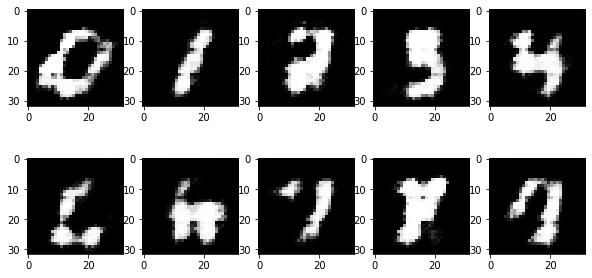

In [27]:
cDCGAN_D_losses = []
cDCGAN_G_losses = []

n_epochs = 2                                                                    # "number of epochs of training"

#label preprocess
onehot = torch.zeros(n_classes, n_classes)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(n_classes,1), 1).view(n_classes, n_classes, 1, 1)
fill = torch.zeros([n_classes, n_classes, img_size, img_size])
for i in range(n_classes):
    fill[i, i, :, :] = 1

for epoch in range(n_epochs):
    cDCGAN_d_avg_loss = 0
    cDCGAN_g_avg_loss = 0

    for n, (images, labels) in enumerate(train_loader):
        d_loss = cDCGAN_train_discriminator(cDCGAN_discriminator, cDCGAN_generator, images, labels, onehot, fill)       # Discriminator 학습
        g_loss = cDCGAN_train_generator(cDCGAN_discriminator, cDCGAN_generator, batch_size, onehot, fill)             # Generator 학습

        cDCGAN_d_avg_loss += d_loss
        cDCGAN_g_avg_loss += g_loss

    cDCGAN_d_avg_loss /= len(train_loader)
    cDCGAN_g_avg_loss /= len(train_loader)
    cDCGAN_D_losses.append(cDCGAN_d_avg_loss)
    cDCGAN_G_losses.append(cDCGAN_g_avg_loss)

    print('Epoch [%3d/%3d], Step[%3d/%3d], d_loss: %.4f, g_loss: %.4f' 
          %(epoch + 1, n_epochs, n+1, len(train_loader), cDCGAN_d_avg_loss, cDCGAN_g_avg_loss))
    
    if (epoch % 10) == 9  or (epoch == n_epochs-1):                              # training 도중 generated image 확인하고 싶은 epoch 설정
        ## test samples(0~9)을 만들어서 generator로 만든 data sample 이미지 확인
        num_test_samples = 10
        test_noise = Variable(torch.randn(num_test_samples, latent_dim).view(-1, 100, 1, 1)).to(device)  
        test_labels = torch.LongTensor([i for i in range(10)]).to(device)
        fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

        test_images = cDCGAN_generator(test_noise,onehot[test_labels].to(device))

        for i in range(num_test_samples):
            ax = axes[i//5,i%5]
            ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

        plt.show()

- Training의 결과로 test sample 0~9 class에 대한 생성 이미지 확인

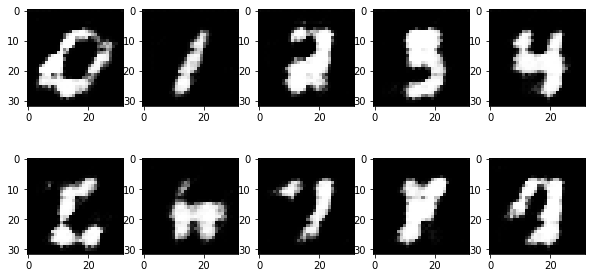

In [30]:
## test samples(0~9)을 만들어서 generator로 만든 data sample 이미지 확인
num_test_samples = 10
test_noise = Variable(torch.randn(num_test_samples, latent_dim).view(-1, 100, 1, 1)).to(device)  
test_labels = torch.LongTensor([i for i in range(10)]).to(device)  
fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

test_images = cDCGAN_generator(test_noise,onehot[test_labels].to(device))

for i in range(num_test_samples):
    ax = axes[i//5,i%5]
    ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

plt.show()

- n_epochs을 키워서 더 길게 training하면 다음과 같은 결과를 얻을 수 있음

    - n_epochs=40:

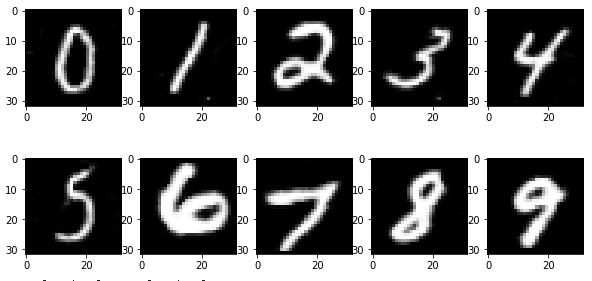


- Tracking을 위해 generator loss와 discriminator loss 변화 plot


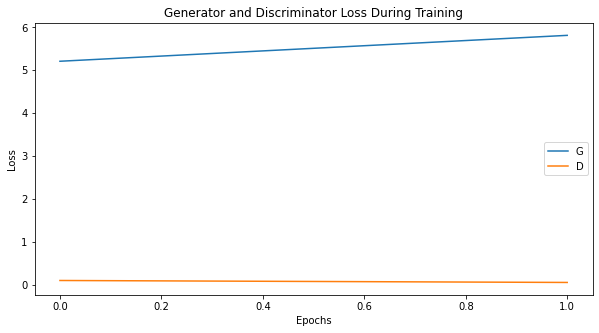

In [31]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")

plt.plot(cDCGAN_G_losses,label="G")
plt.plot(cDCGAN_D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

- n_epochs=40의 loss tracking plot은 다음과 같음:


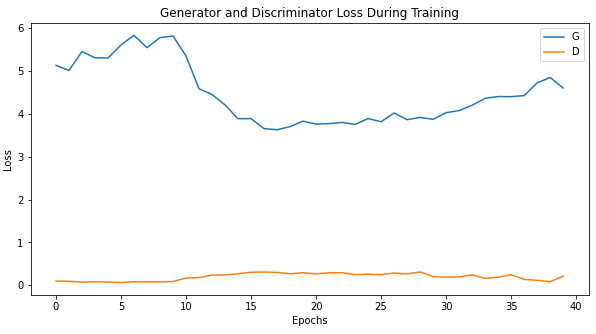

*** Reference ***

1. https://subinium.github.io/VanillaGAN/
2. https://github.com/YBIGTA/Deep_learning/blob/master/GAN/2017-07-29-GAN-tutorial-2-MNIST.markdown
3. https://github.com/arturml/mnist-cgan/blob/master/mnist-cgan.ipynb
4. https://kangbk0120.github.io/articles/2017-08/condgan-imple
5. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
8. https://github.com/togheppi/cDCGAN